In [1]:
from datetime import timedelta
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import pandas as pd

drift_model = 'turnbull'  # must be 'turnbull' or 'wagner'
ocean_model = 'ecmwf'  # must be 'ecmwf'
atm_model = 'ecmwf'  # must be 'ecmwf'
tstepper = 'euler'  # must be euler, ab2, ab3, or ab4



from icedef import iceberg, metocean, plot, timesteppers

if drift_model == 'turnbull':
    from icedef.turnbull import drift
elif drift_model == 'wagner':
    from icedef.wagner import drift
else:
    print('drift model specified is invalid')
    
if tstepper == 'euler':
    from icedef.timesteppers import euler as timestepper
elif tstepper == 'ab2':
    from icedef.timesteppers import ab2 as timestepper
elif tstepper == 'ab3':
    from icedef.timesteppers import ab3 as timestepper
elif tstepper == 'ab4':
    from icedef.timesteppers import ab4 as timestepper
else:
    print('timestepper specified is invalid')

In [2]:
iip_season = 2015
max_hours = 24

iip_df = iceberg.get_dense_df(iip_season, max_hours)

track_num = 0
iip_berg_df = iip_df.loc[iip_df['track_num'] == track_num]

iip_berg = iceberg.get_iip_berg(iip_berg_df)

/home/evankielley/IceDEF/icedef/iceberg.py:403: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  iip_df2['count'] = iip_df2.groupby('ICEBERG_NUMBER')['ICEBERG_NUMBER'].transform('count')


In [3]:
ocean_data = metocean.ECMWFOcean(min(iip_berg.history['X']), max(iip_berg.history['X']),
                         min(iip_berg.history['Y']), max(iip_berg.history['Y']),
                         iip_berg.history['T'][0], iip_berg.history['T'][-1])

ocean_data.filenames

['20150310.nc', '20150311.nc']

In [4]:
atm_data = metocean.ECMWFAtm(min(iip_berg.history['X']), max(iip_berg.history['X']),
                         min(iip_berg.history['Y']), max(iip_berg.history['Y']),
                         iip_berg.history['T'][0], iip_berg.history['T'][-1])

atm_data.filenames

['20150310.nc', '20150311.nc']

In [69]:
class DriftSimulation():
    
        
    OM = 7.2921e-5  # rotation rate of Earth (rad/s)
    RE = 6378*1e3  # radius of Earth (m)
    RHOA = 1.225 # density of air (kg/m^3)
    RHOW = 1027.5  # density of water (kg/m^3)
    RHOI = 900  # density of iceberg (kg/m^3)

    
    
    def __init__(self, berg, ocean, atm, drift):
        
        self.berg = berg
        self.ocean = ocean
        self.atm = atm
        self.drift = drift
        
        self.y_min = min(self.ocean.lats[0], self.atm.lats[0])
        self.y_max = max(self.ocean.lats[-1], self.atm.lats[-1])
        self.x_min = min(self.ocean.lons[0], self.atm.lons[0])
        self.x_max = max(self.ocean.lons[-1], self.atm.lons[-1])
        
        self.dt = 0.1
        self.nt = 10
        
        self.history = pd.DataFrame(columns=['T', 'Y', 'X'])
        
    
    
    
    
    def interpolate(self, t, x, y):

        Vcx, Vcy = self.ocean.interpolate(t, x, y)
        Vax, Vay = self.atm.interpolate(t, x, y)
        
        return Vcx, Vcy, Vax, Vay
    
    
    def in_bounds(self, x, y):
        
        if not self.x_min < x < self.x_max:
            print('Iceberg out of bounds')
            return False
        
        elif not self.y_min < y < self.y_max:
            print('Iceberg out of bounds')
            return False
        
        else:
            return True
    
    
    def meters_to_degrees(self, x, y, dx, dy):
        # x and y are in degrees and dx and dy are in meters
        
        y1 = y + dy*(180/(np.pi * self.RE))
        x1 = x + dx/(np.cos((((y + y1)/2)*np.pi)/180))*(180/(np.pi*self.RE))
        
        
        return x1, y1
    

    def setup_timestepper(self, t0, x0, y0, vx0, vy0, nt):
        
        t = [None]*(nt+1)
        x = np.empty(nt+1)
        y = np.empty(nt+1)
        vx = np.empty(nt+1)
        vy = np.empty(nt+1)
        vcx = np.empty(nt+1)
        vcy = np.empty(nt+1)
        vax = np.empty(nt+1)
        vay = np.empty(nt+1)
        
        
        t[0] = t0
        x[0] = x0
        y[0] = y0
        vx[0] = vx0
        vy[0] = vy0
        
        
        vcx[0], vcy[0], vax[0], vay[0] = self.interpolate(t0, x0, y0)
        
        return t, x, y, vx, vy, vcx, vcy, vax, vay

    
    
    def euler(self, t, x, y, vx, vy, vcy, vcx, vay, vax, dt):
        
        constants = [[vcx, vcy, vax, vay],
                     [self.berg.M,  self.berg.Ak, self.berg.Ab, self.berg.As, self.berg.At],
                     [self.berg.Cdw, self.berg.Cda, self.berg.Csdw, self.berg.Csda],
                     [self.OM, self.RHOW, self.RHOA, self.RHOI]]
        
        
        ax, ay = self.drift(t, x, y, vx, vy, constants)
        
        vx1 = vx + ax*dt
        vy1 = vy + ay*dt

        return vx1, vy1
    
    
    def euler_driver(self, t0, x0, y0, vx0, vy0, dt, nt):
        
        t, x, y, vx, vy, vcx, vcy, vax, vay = self.setup_timestepper(t0, x0, y0, vx0, vy0, nt)
        
        for i in range(nt):
            
            vx[i+1], vy[i+1] = self.euler(t[i], x[i], y[i], vx[i], vy[i], vcy[i], vcx[i], vay[i], vax[i], dt) 
            
            dx = vx[i+1]*dt
            dy = vy[i+1]*dt

            # convert position from meters to degrees
            x[i+1], y[i+1] = self.meters_to_degrees(x[i], y[i], dx, dy)
            
            t[i+1] = t[i] + timedelta(seconds=dt)
             
            if not self.in_bounds(x[i+1], y[i+1]):
                t = t[:i+1]
                x = x[:i+1]
                y = y[:i+1]
                vx = vx[:i+1]
                vy = vy[:i+1]
                vcx = vcx[:i+1]
                vcy = vcy[:i+1]
                vax = vax[:i+1]
                vay = vay[:i+1]
                break
                
            vcx[i+1], vcy[i+1], vax[i+1], vay[i+1] = self.interpolate(t[i+1], x[i+1], y[i+1])
               
            
        return t, x, y, vx, vy, vcx, vcy, vax, vay
    
            
    def rk2(self, t0, x0, y0, vx0, vy0, dt, nt):

        t, x, y, vx, vy, vcx, vcy, vax, vay = self.setup_timestepper(t0, x0, y0, vx0, vy0, nt)
        
        for i in range(nt):
            
            constants = [[vcx[i], vcy[i], vax[i], vay[i]],
                         [self.berg.M,  self.berg.Ak, self.berg.Ab, self.berg.As, self.berg.At],
                         [self.berg.Cdw, self.berg.Cda, self.berg.Csdw, self.berg.Csda],
                         [self.OM, self.RHOW, self.RHOA, self.RHOI]]
        
            ax, ay = self.drift(t[i], x[i], y[i], vx[i], vy[i], constants)
            half_vx = vx[i] + 0.5*dt*ax 
            half_vy = vy[i] + 0.5*dt*ay
            half_dx = dt*half_vx
            half_dy = dt*half_vy
            half_x, half_y = self.meters_to_degrees(x[i], y[i], half_dx, half_dy)
            half_t = t[i] + 0.5*timedelta(seconds=dt)
         
            if not self.in_bounds(half_x, half_y):
                t = t[:i+1]
                x = x[:i+1]
                y = y[:i+1]
                vx = vx[:i+1]
                vy = vy[:i+1]
                vcx = vcx[:i+1]
                vcy = vcy[:i+1]
                vax = vax[:i+1]
                vay = vay[:i+1]
                break
             
            half_vcx, half_vcy, half_vax, half_vay = self.interpolate(half_t, half_x, half_y)

            constants[0] = [half_vcx, half_vcy, half_vax, half_vay]
            half_ax, half_ay = self.drift(half_t, half_x, half_y, half_vx, half_vy, constants)
            
            vx[i+1] = vx[i] + dt*half_ax 
            vy[i+1] = vy[i] + dt*half_ay
            dx = dt*vx[i+1]
            dy = dt*vy[i+1]
            x[i+1], y[i+1] = self.meters_to_degrees(x[i], y[i], dx, dy)
            t[i+1] = t[i] + timedelta(seconds=dt)
         
            if not self.in_bounds(x[i+1], y[i+1]):
                t = t[:i+1]
                x = x[:i+1]
                y = y[:i+1]
                vx = vx[:i+1]
                vy = vy[:i+1]
                vcx = vcx[:i+1]
                vcy = vcy[:i+1]
                vax = vax[:i+1]
                vay = vay[:i+1]
                break
             
            vcx[i+1], vcy[i+1], vax[i+1], vay[i+1] = self.interpolate(t[i+1], x[i+1], y[i+1])

        return t, x, y, vx, vy, vcx, vcy, vax, vay

In [70]:
sim = DriftSimulation(iip_berg, ocean_data, atm_data, drift)

In [71]:
sim.interpolate(sim.berg.T, sim.berg.X, sim.berg.Y)

(-0.074432678172666411,
 -0.18025457901431347,
 4.4437250000353208,
 1.9600972221737267)

In [73]:
t, x, y, vx, vy, vcx, vcy, vax, vay = sim.euler_driver(sim.berg.T, sim.berg.X, sim.berg.Y, sim.berg.Vx, sim.berg.Vy, 0.1*3600, 100)

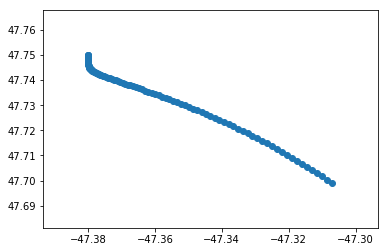

In [74]:
plt.scatter(x, y)
plt.show()

In [75]:
t, x, y, vx, vy, vcx, vcy, vax, vay = sim.rk2(sim.berg.T, sim.berg.X, sim.berg.Y, sim.berg.Vx, sim.berg.Vy, 0.1*3600, 100)

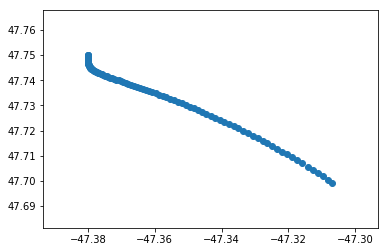

In [76]:
plt.scatter(x, y)
plt.show()